# Kaggle: Digit Recognizer (MNIST) точность 0.99585

[Мой блог](https://tiendil.org)

[Пост об этом notebook](https://tiendil.org/kaggle-digit-recognizer-solution)

Моё решение учебного соревнования [Kaggle](https://www.kaggle.com/): [digit-recognizer](https://www.kaggle.com/c/digit-recognizer/) по расспознаванию рукописных символов из набора [MNIST](https://en.wikipedia.org/wiki/MNIST_database).

На момент отправки решение занимало 467 место из ~7000. На мой взгляд неплохой результат, учитывая, что первые мест 200 занимают читерские решения. MNIST — общедоступный набор данных, их можно скачать вне kaggle и залить в качестве решения готовые ответы, или обучить сеть на всём наборе.

Размещаю notebook тут, а не на Kaggle, так как результаты из лидербордов учебных соревнований трутся через несколько месяцев, а отдельно висящих notebooks для MNIST там и так хватает, есть и лучше.

Ссылки на Google Colab тоже не будет, так как их окружение сильно отличается от моего, надо обновлять много пакетов. Со временем различия будут только копиться, что сведёт полезность такой ссылки к нулю.

Часть кода взята из моего [предыдущего notebook](https://github.com/Tiendil/public-jupyter-notebooks/blob/main/simplest-dl-workflow/notebook.ipynb)

## Подготовка

Notebook запускался в кастомизированном docker контейнере.

Подробнее про мои злоключения с настройкой tensorflow + CUDA можно почитать в блоге: [нельзя просто так взять и запустить DL](https://tiendil.org/you-cant-just-take-and-run-dl).

Официальная документация о [запуске tensorflow через docker](https://www.tensorflow.org/install/docker).

Dockerfile: 

```
FROM tensorflow/tensorflow:2.5.0-gpu-jupyter

RUN apt-get update && apt-get install -y graphviz # requeired by tensorflow to visualize models

RUN pip install --upgrade pip

COPY requirements.txt ./

RUN pip install -r ./requirements.txt

COPY kaggle.json /root/.kaggle/

# kaggle output warning, without stricter file permissions
RUN chmod 600 /root/.kaggle/kaggle.json

```

requirements.txt:
```
pandas==1.1.5
kaggle==1.5.12
pydot==1.4.2  # requeired by tensorflow to visualize models
livelossplot==0.5.4  # required to plot loss while training
albumentations==1.0.3  # augument image data

```

## Инициализация

In [1]:
# Импортируем нужные пакеты.
# Настраиваем самые важные параметры.

import os
import random
import logging
import datetime

# Это нужно для более правильного и красивого вывода.
# На сколько я понимаю, использовать print — моветон.
from IPython.display import display, Markdown, Image, Latex
import ipywidgets as ipw

# Меняем уровень логирования tensorflow ПЕРЕД его импортом.
# Если это не сделать, библиотека будет выводить кучу сообщений информационного характера. 
# Ради интереса можете закомментировать следующую строчку и почитать их — познавательно.
# Подробнее смотрите тут: https://stackoverflow.com/questions/35911252/disable-tensorflow-debugging-information
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

from livelossplot import PlotLossesKerasTF

# биндинги для OpenCV — библиотеки Computer Vision
# используется в albumentations
# импортируем, так как нужны некоторые константы
import cv2 

# библиотека для аугументации изображений
import albumentations as alb

# Настраиваем оставшиеся логеры
logging.getLogger().setLevel(logging.WARNING)

tf.get_logger().setLevel(logging.WARNING)
tf.autograph.set_verbosity(1)

# Включаем строгий режим операций для numpy — при любом warning будет кидаться ошибка
# Полезно, чтобы не напутать с типами данных. Особенно, если логирование отключено/уменьшено.
old_settings = np.seterr('raise')

# Проверяем есть ли доступные GPU
gpus = tf.config.list_physical_devices("GPU")

display(Markdown(f'Num GPUs Available: {len(gpus)}'))

if not gpus:
    raise RuntimeError('No GPUs found, learning process will be too slow. In Google Colab set runtime type — GPU.')
    
display(Markdown(f'Eager mode: {tf.executing_eagerly()}'))

# Говорим tensorflow не резервировать всю память на карте. Нам ещё браузером пользоваться и прочими штуками.
tf.config.experimental.set_memory_growth(gpus[0], True)

Num GPUs Available: 1

Eager mode: True

In [2]:
# Фиксируем генераторы случайных чисел для воспроизводимости.
# Способ фиксации не полный и не гарантирует 100% воспроизводимости для этого notebook
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Очищаем данные Keras. 
# Добавлено, чтобы освобождать память видеокарты. 
# Это важно, если, например, вы поочерёдно запускаете несколько notebook. 
tf.keras.backend.clear_session()

# создаём генератор случайных чисел
RNG = np.random.default_rng()

## Вспомогательные функции

Можно не вчитываться.

In [3]:
# Разделяет данные в dataset на несколько частей заданного размера.
def split_dataset(data, *parts, cache):
    data_size = data.cardinality()
    assert data_size == sum(parts), \
           f"dataset size must be equal to sum of parts: {data_size} != sum{parts}"
    
    result = []
    
    for part in parts:
        data_part = data.take(part)
        
        if cache:
            data_part = data_part.cache()
        
        result.append(data_part)
        
        data = data.skip(part)
        
    return result


def normalizer(minimum, maximum): 
    def normalize_dataset(x):
        return (x - minimum) / (maximum - minimum)
    return normalize_dataset

# Рисует структуру модели средствами Keras. Простой способ визуализировать модель. Но не очень информативный.
def display_model(model, name):
    filename = f'/tmp/tmp_model_schema_{name}.png'
    
    keras.utils.plot_model(model, 
                           show_shapes=True, 
                           show_layer_names=True, 
                           show_dtype=True,
                           expand_nested=True,
                           to_file=filename)
    display(Image(filename))
    
# Вспомогательный класс для генерации имён слоёв в модели. 
# Чтобы потом было проще читать логи и схемы.
class LayersNameGenerator:
    __slots__ = ('prefix', 'number')
    
    _version = 0
    
    def __init__(self, prefix):
        self.prefix = prefix
        self.number = 0
        
        self.__class__._version += 1
        
    def __call__(self, type_name, name=None):
        self.number += 1
        
        if name is None:
            name = str(self.number)
            
        return f'{self.prefix}.{self._version}-{type_name}.{name}'   
    

# Отображаем картинки.
def display_examples(examples_number, data_number, image_getter, label_getter=lambda j: ''):
    examples_number = min(examples_number, data_number)
    
    plt.figure(figsize = (16, 16))

    for i, j in enumerate(RNG.choice(data_number, examples_number, replace=False)):
        plt.subplot(1, examples_number, i+1)
        plt.imshow(image_getter(j), cmap=plt.get_cmap('gray'))
        plt.title(label_getter(j))
        
        
def display_memory_stats():
    stats = tf.config.experimental.get_memory_info('GPU:0')
    message = f'''
    current: {stats["current"]/1024/1024}Mb
    peak: {stats["peak"]/1024/1024}Mb
    '''
    display(Markdown(message))
    
    
def make_report(history, main, metrics):  
    groups = {'main': {}}
    
    for key in history.history.keys():
        if key in ('loss', 'val_loss', 'accuracy', 'val_accuracy'):
            if key.startswith('val_'):
                metric = key
            else:
                metric = f'train_{key}'
                
            groups['main'][metric] = history.history[key][-1]
            continue
            
        if not any(key.endswith(f'_{metric}') for metric in metrics):
            continue
            
        group, metric = key.rsplit('_', 1)
              
        validation = False
        
        if group.startswith('val_'):
            group = group[4:]
            validation = True
        
        if group not in groups:
            groups[group] = {}
            
        if validation:
            metric = f'val_{metric}'
        else:
            metric = f'train_{metric}'
            
        groups[group][metric] = history.history[key][-1]
        
    lines = []
    
    for group, group_metrics in groups.items():
        lines.append(f'**{group}:**')
        lines.append(f'```')
        
        for name, value in sorted(group_metrics.items()):
            if name in ('accuracy', 'val_accuracy', 'train_accuracy'):
                lines.append(f'  {name}: {value:.4%} ({value})')
            else:
                lines.append(f'  {name}: {value}')
            
        lines.append(f'```')
        
    train_loss = groups[main]['train_loss']
    val_loss = groups[main]['val_loss']
    val_accuracy = groups[main]['val_accuracy']
        
    history.history[key][-1]
        
    description = f'train_loss: {train_loss:.4}; val_loss: {val_loss:.4}; val_acc: {val_accuracy:.4%}'
    
    lines.append(f'**description:** {description}')
            
    return '\n\n'.join(lines), description

## Получение данных MNIST

In [4]:
# Скачиваем данные специализированной утилитой
!kaggle competitions download -c digit-recognizer

digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
import zipfile

archive = zipfile.ZipFile('digit-recognizer.zip')

archived_files = archive.namelist()

FILE_TEST = 'test.csv'
FILE_TRAIN = 'train.csv'

if FILE_TEST not in archived_files or FILE_TRAIN not in archived_files:
    raise RuntimeError('Can not find required files. Something wrong with archive.')
    
raw_train_data = pd.read_csv(archive.open(FILE_TRAIN))

display(raw_train_data.shape)
display(raw_train_data)

(42000, 785)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Смотрим на данные

In [6]:
# Используем именованные константы вместо хардкода
# Чтобы код был устойчивее к изменениям
IMAGE_SIZE = 28
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE)
INPUT_SHAPE = (*IMAGE_SHAPE, 1)

In [7]:
# Разделяем значения входов и выходов и производим базовую подготовку данных

# Эта функция ещё понадобится при обработке неразмеченных данных для kaggle
def prepair_x(raw_x):
    x = raw_x.values.astype('float32')
    return x.reshape(x.shape[0], *INPUT_SHAPE)
    
input_x = prepair_x(raw_train_data.iloc[:,1:])
input_y = raw_train_data.iloc[:,0].values.astype('int32')

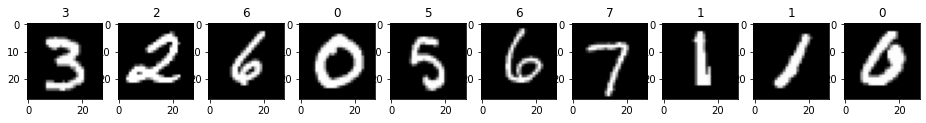

In [8]:
# смотрим на картинки
display_examples(examples_number=10, 
                 data_number=len(input_x), 
                 image_getter=lambda j: input_x[j], 
                 label_getter=lambda j: input_y[j]) 

<BarContainer object of 10 artists>

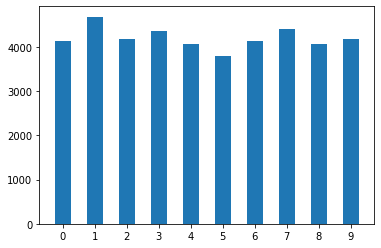

In [9]:
# смотрим на распределение картинок по классам
labels, counts = np.unique(input_y, return_counts=True)

display(plt.bar(labels, counts, width=0.5, tick_label=labels))

## Готовим данные для обучения

Чтобы обучение сети происходило эффективно, тренировочные и валидационные данные необходимо подготовить.

Во-первых — очистить, унифицировать и т.п. Поскольку мы работаем с MNIST нам это делать не надо — за нас уже всё сделали.

Во-вторых, преобразовать в формат, удобный для нашей сети. Для этого мы нормализуем данные — перейдём от целочисленного формата пикселей (от 0 до 255) к дробному (от 0.0 до 1.0).

В-третьих, расширить (термин для гугления: data augumentation) обучающую выборку, чтобы у сети было больше примеров. Для этого мы будем немного масштабировать, сдвигать и вращать доступные нам картинки. 

Делать это можно двумя способами:

- offline — сгенерировать дополнительные данные один раз и учиться на их статическом наборе.
- online — генерировать новые данные для каждой эпохи.

Выбор конкретного способа зависит от задачи и доступных ресурсов. Поскольку данных у нас не много, модифицировать на лету их не сложно, я выбрал второй вариант.

In [10]:
DATA_NUMBER = len(input_y)

# Доступные нам данные разобьём на обучающие и валидационные в отношении 90%/10%.
# Валидацпионную выборку будем использовать в качестве критерия остановки обучения и предотвращения переобучения.
# Как только показатели для этой выборки перестали улучшаться, считаем сеть обученной.
TRAIN_FRACTION = 0.9
TRAIN_EXAMPLES = int(TRAIN_FRACTION * DATA_NUMBER)
VALIDATION_EXAMPLES = DATA_NUMBER - TRAIN_EXAMPLES


def preprocess_x(input_x):
    x = input_x.reshape(input_x.shape[0], *INPUT_SHAPE)
    
    x = tf.data.Dataset.from_tensor_slices(x)
    
    # нормализуем данные в картинках
    x_minimum = np.amin(input_x)
    x_maximum = np.amax(input_x)
      
    return x.map(normalizer(x_minimum, x_maximum))


def preprocess_y(input_y):
    # Преобразуем идентификаторы классов (0,1,2,…,9) в binary class matrix, не знаю как правильно по-русски :-)
    # Нейронной сети проще работать с качественными/бинарными признаками а-ля «это 9? да/нет».
    # Поэтому метки классов преобразуются в one-hot vector (https://en.wikipedia.org/wiki/One-hot).
    # А-ля 2 -> [0, 0, 1, 0, …]; 5 -> [0, 0, 0, 0, 0, 5, …]
    # Подробнее в документации: https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
    y = tf.keras.utils.to_categorical(input_y)
    return tf.data.Dataset.from_tensor_slices(y)


# Функция делает предобработку данных и объединяет их в один набор
def preprocess(input_x, input_y):  
    x = preprocess_x(input_x)
    y = preprocess_y(input_y)
    
    d = tf.data.Dataset.zip((x, y))
    
    d = d.shuffle(buffer_size=len(d))
    
    # .cache — возвращает dataset, который не будет изменяться при различных вызовах
    # это полезно по-двум причинам:
    # - не будет происходить перерасчёт данных (нормализация и т.п.) при каждом проходе по ним;
    # - если при обработке происходили случайные изменения данных, они будут зафиксированы 
    #   и будут иметь одно и то же значение на каждом проходе по ним
    #
    # .cache будет использоваться далее ещё в некоторых местах
    # На мой взгляд, им можно заканчивать каждую замкнутую операцию с данными, результат которой должен быть зафиксирован
    # Во время прототипрования код меняется быстро, если забыть что данные не закешированы,
    # можно словить сложноотслеживаемые тормоза или неконсистентность данных.
    return d.cache()

# после этой строчки у нас будет «стандартизованый» набор данных для обучения.
DATA = preprocess(input_x, input_y)

display(Markdown(f'full data shape: {DATA}'))

# Получаем обучающую и валидационную выборку
# Итоговые dataset тоже кэшируются
data_train, data_validation = split_dataset(DATA, 
                                            TRAIN_EXAMPLES, 
                                            VALIDATION_EXAMPLES,
                                            cache=True)


# Функция расширяющая набор данных с помощью библиотеки albumentations
# p — вероятность применения преобразований к конкретному изображению
def augumenting(d, p):
    # Перемешиваем исходный dataset
    # Он будет подаваться сети кусками (batches).
    # Перемешав данные перед формированием этих кусков, мы сделаем каждый кусок уникальным. 
    # То есть данные, на которых учится сеть, станут разнообразнее, что улучшит поиск глобального оптимума.
    # В случае этой задачи, добавление перемешивания само по себе значительно улучшило показатели сети.
    d = d.shuffle(buffer_size=len(d))
        
    # Описываем преобращования данных, указываем границы сдвина, вращения, изменения масштаба.
    # Cтавить большой угол поворота не надо, так как нейронка начнёт видеть 6 как 9, 7 как перевёрнутую 2, etc.
    transforms = alb.Compose([alb.ShiftScaleRotate(shift_limit=0.15, 
                                                   scale_limit=0.15, 
                                                   rotate_limit=15, 
                                                   interpolation=cv2.INTER_CUBIC, 
                                                   border_mode=cv2.BORDER_CONSTANT, 
                                                   value=0.0, 
                                                   p=p)])
    
    def transformer(x):
        data = transforms(image=x)
        return data['image']
    
    def mapper(x, y):
        x = tf.numpy_function(func=transformer, inp=[x], Tout=tf.float32)
        return x, y
    
    # Применяем преобразования. 
    # Тут dataset не кешируем, чтобы на кажом цикле обучения сеть получала новые данные.
    return d.map(mapper)

# Формируем реальную обучающую выборку.
# Каждая эпоха обучения будет получать 50% исходных данных, 50% модифицированных.
data_train = augumenting(data_train, p=0.5)

# data_validation не трогаем

full data shape: <CacheDataset shapes: ((28, 28, 1), (10,)), types: (tf.float32, tf.float32)>

## Конструируем модель

По архитектуре модели мало что интересного можно сказать — она относительно проста и будет видна на графе ниже. 

В условиях остутствия реального опыта, сеть строилась итерационно, опираясь на чуйку и шаткие представления о работе всего этого :-)

Хорошее улучшение показателей дало добавление слоёв [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) после [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense). 
А вот их добавление после [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) вызывало странное поведение сети: показатели сети на валидационной выборке начинали ухудшаться на протяжении первых эпох 20, после чего улучшались, но не улучшали результат. На сколько я вижу по другим решениям, так быть не должно. Я нашёл несколько возможных объяснений, но пока до конца не разобрался.

In [11]:
def construct_model():
    names = LayersNameGenerator('mnist')
    
    inputs = keras.Input(shape=INPUT_SHAPE, name=names('Input'))
    
    branch = inputs
    
    branch = layers.Conv2D(2**7, (5, 5), activation='elu', name=names('Conv2D'))(branch)
    
    branch = layers.MaxPooling2D((3, 3), (2, 2), name=names('MaxPooling2D'))(branch)
    
    branch = layers.Conv2D(2**8, (3, 3), activation='relu', name=names('Conv2D'))(branch)
         
    branch = layers.Flatten(name=names('Flatten'))(branch)
       
    branch = layers.Dense(2**10, activation="elu", use_bias=True, name=names('Dense'))(branch)
    
    branch = layers.BatchNormalization(name=names('BatchNormalization'))(branch)
    
    branch = layers.Dense(2**7, activation="relu", use_bias=True, name=names('Dense'))(branch) 
    
    branch = layers.BatchNormalization(name=names('BatchNormalization'))(branch)
    
    outputs = layers.Dense(10, activation='softmax', name=names('Dense'))(branch)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model


model = construct_model()

model.compile(optimizer=keras.optimizers.RMSprop(centered=True),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

## Базовые проверки

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.11517566, 0.08987234, 0.1061188 , 0.10282896, 0.09056489,
        0.09785405, 0.10259971, 0.09160702, 0.10418604, 0.09919246]],
      dtype=float32)>

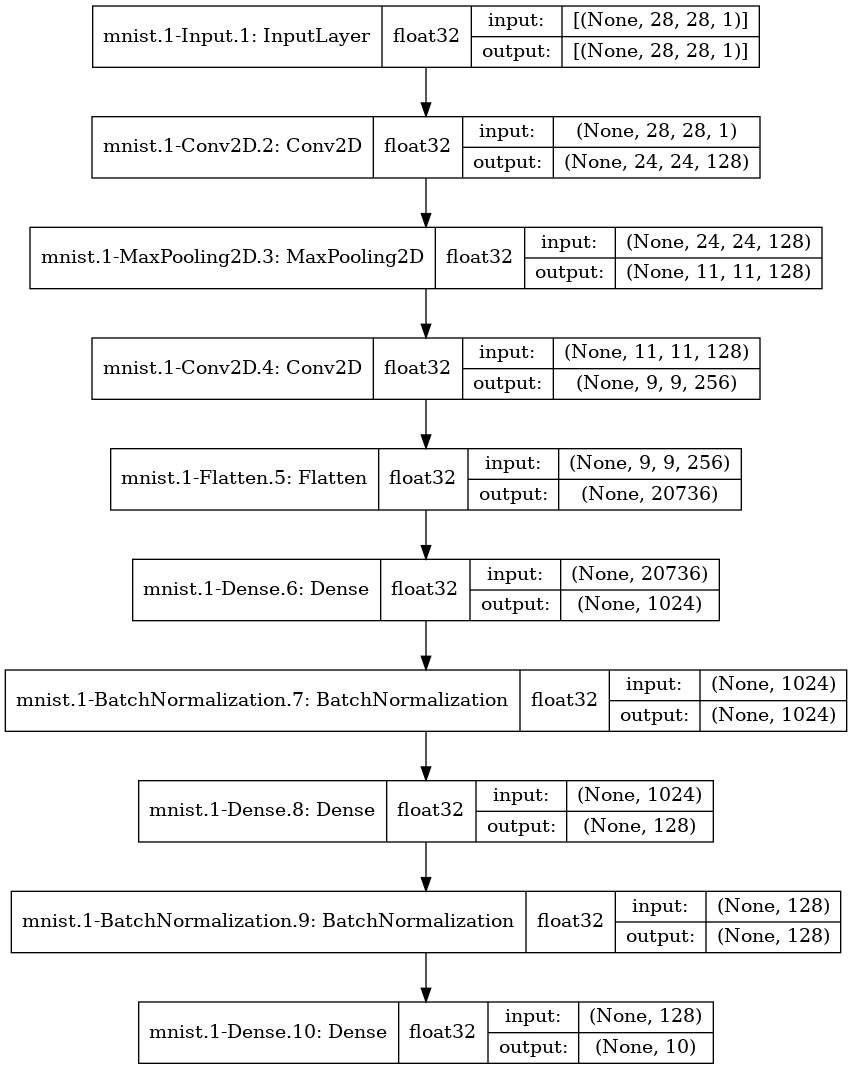

In [12]:
# Проверяем, что модель в принципе что-то считает
check_input = tf.constant(RNG.random((1, *INPUT_SHAPE)), shape=(1, *INPUT_SHAPE))
display(model(check_input))

# Визуализируем граф модели.
display_model(model, 'model')

## Обучаем модель

In [13]:
# Задаём параметры обучения

# Сколько раз цикл обучения пройдёт по всем обучающим данным
EPOCHS = 10000

# За один шаг будем обучать сеть на таком количестве данных
BATCH_SIZE = int(TRAIN_EXAMPLES * 0.1)


display(Markdown(f'batch size: {BATCH_SIZE}'))
display(Markdown(f'epochs: {EPOCHS}'))

batch size: 3780

epochs: 10000

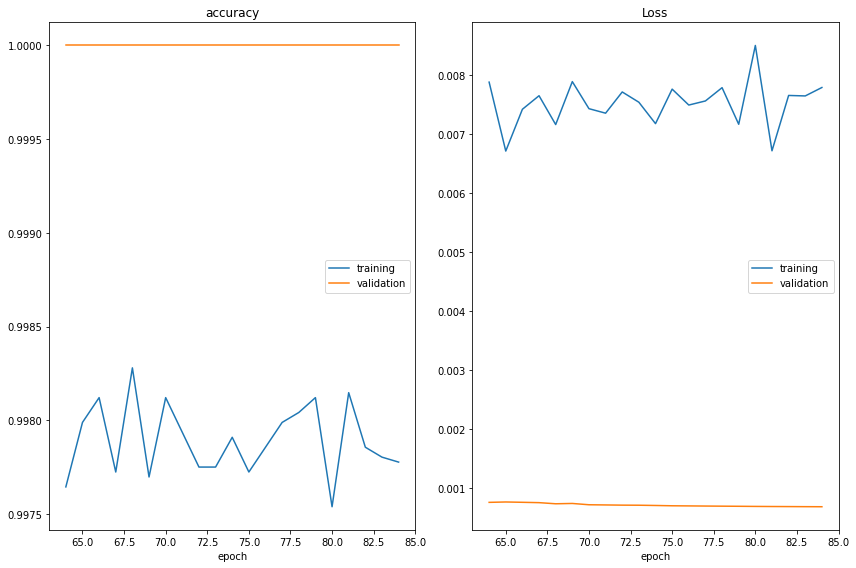

In [14]:
# Явно формируем dataset для скармливания сети во время обучения.
# Разбиваем на куски и говорим готовить их заранее.
data_for_train = data_train.batch(BATCH_SIZE, drop_remainder=True).prefetch(buffer_size=10)
data_for_validation = data_validation.batch(BATCH_SIZE).prefetch(buffer_size=10)

#Указываем параметры обучения

# Количество эпох без улучшения показателей валидационной выборки, после которых обучение останавливается.
# Используется в трёх callbacks:
# - EarlyStopping непосредственно останавливает обучение.
# - ReduceLROnPlateau уменьшает скорость обучения при длительном отсутствии изменений
# - PlotLossesKerasTF рисует график с областью равной patience — так удобнее — лучше видны изменения.
patience = 20  

# Поскольку EarlyStopping и ReduceLROnPlateau используют разные значения по-умолчанию для определения изменений,
# унифицируем его.
plateau_min_delta = 0.0001

# Запускаем обучение.
# Помимо прочего указываем EarlyStopping восстановить веса с первым лучшим результом валидации на плато.
# Чтобы ещё уменьшить шанс переобучения.
history = model.fit(data_for_train,
                    epochs=EPOCHS,
                    validation_data=data_for_validation,
                    callbacks=[PlotLossesKerasTF(from_step=-patience,
                                                 outputs=['MatplotlibPlot']),
                               tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                                min_delta=plateau_min_delta,
                                                                restore_best_weights=True,
                                                                patience=patience),
                               tf.keras.callbacks.ReduceLROnPlateau(min_delta=plateau_min_delta,
                                                                    patience=patience//3)])

In [15]:
# статистика использованой памяти
display_memory_stats()


    current: 389.6162109375Mb
    peak: 5893.58203125Mb
    

In [16]:
# Формируем небольшой отчёт об обучении
# Отчёт показывает последние данные, что не совсем соответствует реальности —
# веса сети откатываваются момент первого лучшего результата валидации на плато. 
report, description = make_report(history, 'main', ['loss', 'accuracy'])
    
display(Markdown(report))

**main:**

```

  train_accuracy: 99.7778% (0.9977777600288391)

  train_loss: 0.007784143090248108

  val_accuracy: 100.0000% (1.0)

  val_loss: 0.0006906437338329852

```

**description:** train_loss: 0.007784; val_loss: 0.0006906; val_acc: 100.0000%

## Анализируем работу модели

Ищем ошибки в валидационной выборке и во всех данных в целом. Отображаем проблемные картинки.

In [17]:
def search_errors(name, data):
    n = len(data)
    
    validation_x = next(iter(data.map(lambda x, y: x).batch(n)))
    validation_y = np.argmax(next(iter(data.map(lambda x, y: y).batch(n))), axis=1)

    resulted_y = model.predict(validation_x, verbose=0)
    resulted_y = np.argmax(resulted_y, axis=1)

    failed_data = []

    for i, (expexted, result) in enumerate(zip(validation_y, resulted_y)):
        if expexted != result:
            failed_data.append((i, expexted, result))
            
    failed = len(failed_data)
    
    accuracy = float(failed) / n
        
    display(Markdown(f'{name}, failed validation examples: {failed}, accuracy: {accuracy}'))
    
    return failed_data

failed_validation = search_errors('validation', data_validation)
failed_data = search_errors('all', DATA)

validation, failed validation examples: 0, accuracy: 0.0

all, failed validation examples: 9, accuracy: 0.00021428571428571427

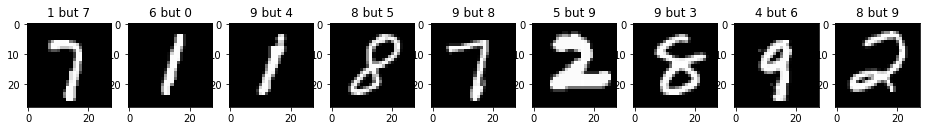

<Figure size 1152x1152 with 0 Axes>

In [18]:
def display_failed_examples(data, failed_data):
    data_x = next(iter(data.map(lambda x, y: x).batch(len(data))))
    
    display_examples(examples_number=10, 
                     data_number=len(failed_data), 
                     image_getter=lambda j: data_x[j], 
                     label_getter=lambda j: f'{failed_data[j][1]} but {failed_data[j][2]}')
        
display_failed_examples(DATA, failed_data)
display_failed_examples(data_validation, failed_validation)

## Подготавливаем данные для kaggle

In [19]:
# Смотрим на данные
raw_test_data = pd.read_csv(archive.open(FILE_TEST))

display(raw_test_data.shape)
display(raw_test_data)

(28000, 784)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
# Подготавливаем данные
test_input_x = prepair_x(raw_test_data)

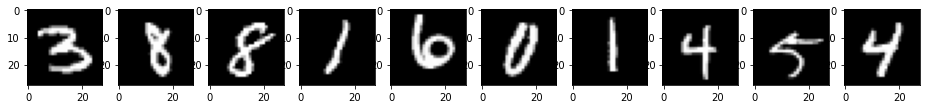

In [21]:
# Смотрим на картинки
display_examples(examples_number=10, 
                 data_number=len(test_input_x), 
                 image_getter=lambda j: test_input_x[j]) 

In [22]:
# Производим предобработку
data_test = preprocess_x(test_input_x)

In [23]:
# Предсказываем
SUBMISSION_FILE = 'digit-recognizer-predictions.csv'

data_for_prediction = data_test.batch(BATCH_SIZE).prefetch(buffer_size=10)

predictions = model.predict(data_for_prediction, verbose=0)

predicted_labels = np.argmax(predictions, axis=1)

In [24]:
# Записываем результат в CSV
submissions=pd.DataFrame({"ImageId": list(range(1,len(predicted_labels)+1)),
                          "Label": predicted_labels})
submissions.to_csv(SUBMISSION_FILE, index=False, header=True)

In [25]:
# Количество попыток в день на Kaggle ограничено.
# Поэтому мы не хотим каждый запуск notebook заканчивать отправкой решения.
# Вместо этого мы делаем кнопку, которая отправляет текущее решение с комментарием из отчёта.
button = ipw.Button(description='Send to Kaggle')

def send_to_kaggle(btn):
    !kaggle competitions submit -c digit-recognizer -f "$SUBMISSION_FILE" -m "$description"
    
button.on_click(send_to_kaggle)

display(button)

Button(description='Send to Kaggle', style=ButtonStyle())